<a href="https://colab.research.google.com/github/tshabalalasibongile/GeoAnomaly-Detection/blob/main/A5_L8_GeoAnomaly_Tshabalala_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GeoAnomaly Detection
# Sibongile Tshabalala (2356121)

# Imports

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

#reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#IO setup
INPUT_CSV = "Processed_Assen_RS_data.csv"
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

#plot defaults
plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style('whitegrid')

#helper for consistent figure saving
def savefig(fig, fname, dpi=300):
  path = os.path.join(OUTDIR, fname)
  fig.savefig(path, dpi=dpi, bbox_inches='tight')
  print(f"Saved {path}")

# 1. Load and Inspect Data

In [ ]:
df = pd.read_csv(INPUT_CSV)
df = pd.read_csv(INPUT_CSV)
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst rows:")
display(df.head())

print("\nMissingness per column:")
display(df.isna().sum())

# a tidy preview of numeric columns
display(df.select_dtypes(include=[np.number]).describe().T)

# detect coordinate columns
has_lonlat = ('Longitude' in df.columns) and ('Latitude' in df.columns)
print("\nHas Longitude/Latitude:", has_lonlat)

Dataset shape: (48848, 10)

Columns: ['Unnamed: 0', 'Longitude', 'Latitude', 'Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7']

First rows:


Unnamed: 0  Longitude   Latitude  Band1  Band2  Band3  Band4  Band5  Band6  \
0           0  27.564250 -25.105965    188    227    363    406    750    709   
1           1  27.564548 -25.105963    126    144    215    166    917    479   
2           2  27.564845 -25.105962    141    187    421    310   2263    947   
3           3  27.565143 -25.105961    111    170    402    291   2558   1154   
4           4  27.565440 -25.105960    232    365    658    779   2409   2199   

   Band7  
0    440  
1    232  
2    438  
3    562  
4   1319


Missingness per column:


Unnamed: 0    0
Longitude     0
Latitude      0
Band1         0
Band2         0
Band3         0
Band4         0
Band5         0
Band6         0
Band7         0
dtype: int64

count          mean           std         min           25%  \
Unnamed: 0  48848.0  24423.500000  14101.347312    0.000000  12211.750000   
Longitude   48848.0     27.606466      0.024398   27.564250     27.585356   
Latitude    48848.0    -25.128960      0.013452  -25.152291    -25.140607   
Band1       48848.0    251.722547     94.493587    0.000000    186.000000   
Band2       48848.0    316.526327    106.311331   62.000000    248.000000   
Band3       48848.0    509.547433    145.656643  149.000000    436.000000   
Band4       48848.0    609.615419    238.682890  121.000000    467.000000   
Band5       48848.0   1648.147539    446.999961  150.000000   1382.000000   
Band6       48848.0   1801.414490    469.584012  141.000000   1539.000000   
Band7       48848.0   1216.814609    432.462650  102.000000    937.750000   

                     50%           75%           max  
Unnamed: 0  24423.500000  36635.250000  48847.000000  
Longitude      27.606466     27.627580     27.648697  
Latitude      -25.128958    -25.117309    -25.105620  
Band1         245.000000    312.000000    968.000000  
Band2         312.000000    377.000000   1171.000000  
Band3         498.000000    562.000000   1834.000000  
Band4         577.000000    706.000000   2558.000000  
Band5        1585.000000   1865.000000   5025.000000  
Band6        1830.000000   2070.000000   4031.000000  
Band7        1196.000000   1454.000000   3158.000000


Has Longitude/Latitude: True


# 2. Detect Band Columns & Spatial EDA

Detected band columns: ['Band1', 'Band2', 'Band3', 'Band4', 'Band5', 'Band6', 'Band7']
GeoDataFrame bounds: [ 27.56425034 -25.15229105  27.64869709 -25.10562034]
Plotting Band1
Saved outputs/Band1_map.png


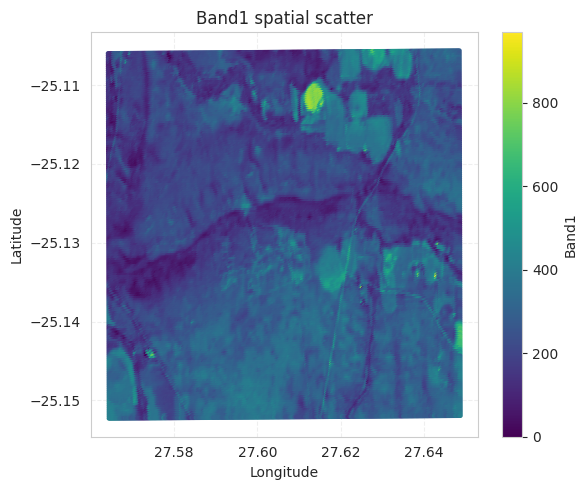

Plotting Band2
Saved outputs/Band2_map.png


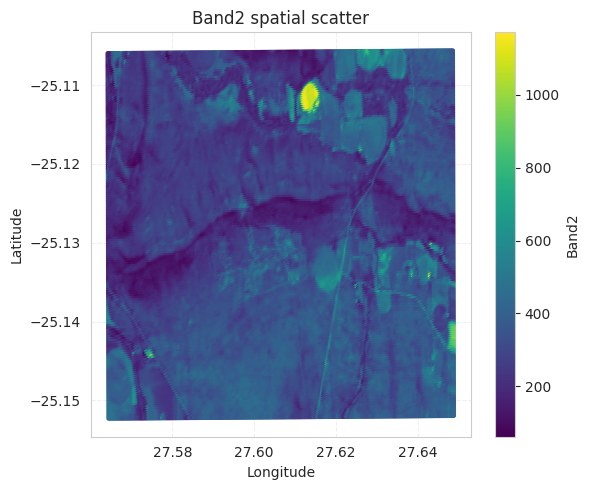

Plotting Band3
Saved outputs/Band3_map.png


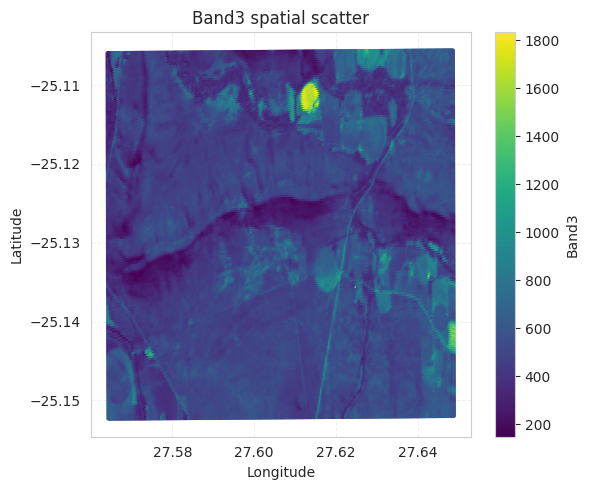

Plotting Band4
Saved outputs/Band4_map.png


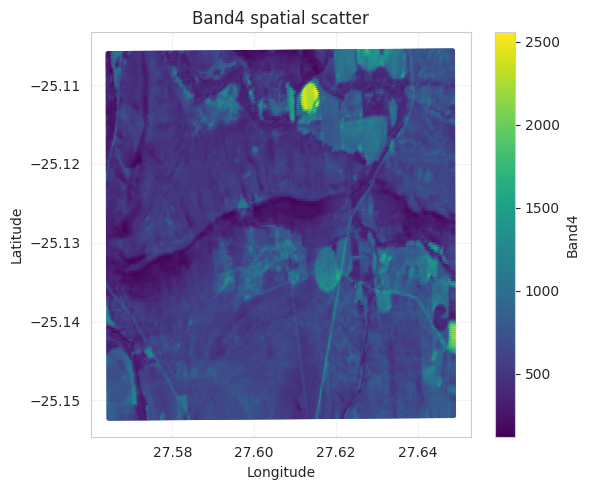

Plotting Band5
Saved outputs/Band5_map.png


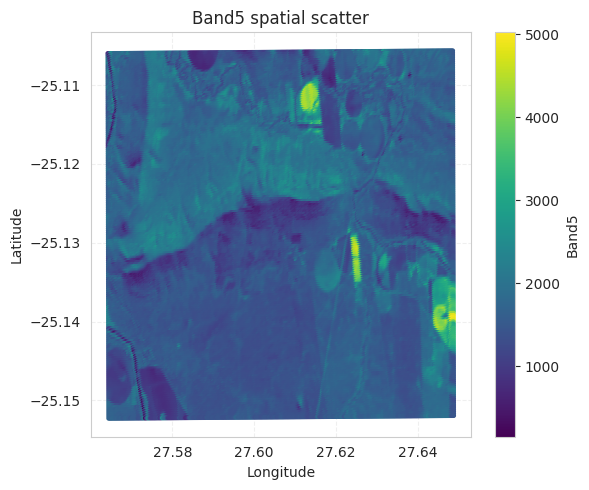

Plotting Band6
Saved outputs/Band6_map.png


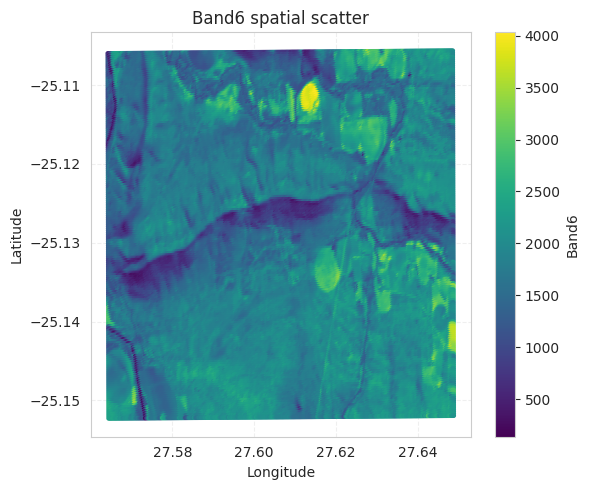

In [ ]:
# Detect band columns

def detect_band_columns(df):
    cols = df.columns.tolist()
    band_cols = [c for c in cols if c.lower().startswith('band')]
    # also include 'B1' 'B2' style
    band_cols += [c for c in cols if (len(c)>=2 and (c[0].lower()=='b' and c[1].isdigit()))]
    band_cols = sorted(list(set(band_cols)))
    # fallback common names
    if not band_cols:
        candidates = [f'Band{i}' for i in range(1,13)]
        band_cols = [c for c in cols if c in candidates]
    return band_cols

band_cols = detect_band_columns(df)
print("Detected band columns:", band_cols)

if len(band_cols) == 0:
    raise ValueError("No band columns detected. Please check column names in CSV.")


#Spatial EDA & correlations

# create GeoDataFrame if coordinates exist
if has_lonlat:
    gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')
    print("GeoDataFrame bounds:", gdf.total_bounds)
else:
    gdf = None

# quick function for scatter maps
def quick_map_scatter(df_map, x='Longitude', y='Latitude', c=None, title=None, cmap='viridis', s=6, save_name=None):
    fig, ax = plt.subplots(figsize=(6,5))
    if c is not None and c in df_map.columns:
        sc = ax.scatter(df_map[x], df_map[y], c=df_map[c], s=s, cmap=cmap)
        cbar = plt.colorbar(sc, ax=ax)
        cbar.set_label(c)
    else:
        ax.scatter(df_map[x], df_map[y], s=s, color='k')
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.set_title(title or c or 'map')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    if save_name:
        savefig(fig, save_name)
    plt.show()

# show first few band maps (first 6 or available)
for b in band_cols[:6]:
    print("Plotting", b)
    if has_lonlat:
        quick_map_scatter(gdf, c=b, title=f"{b} spatial scatter", save_name=f"{b}_map.png")
    else:
        print("No coordinates for mapping.")


# 3. Correlations and Pairwise Relationships

Saved outputs/band_correlation_heatmap.png


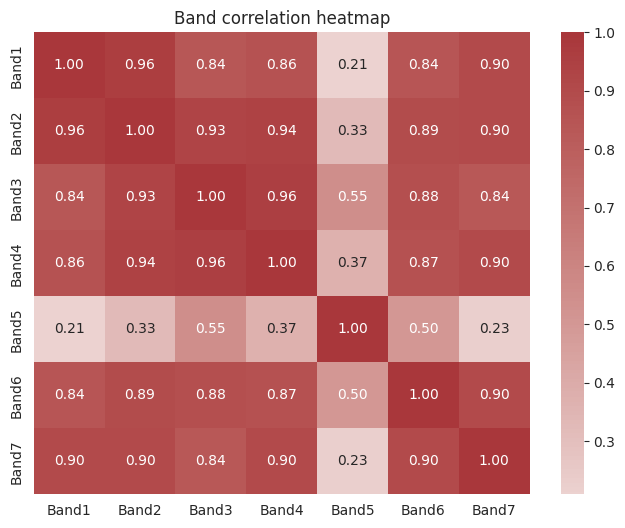

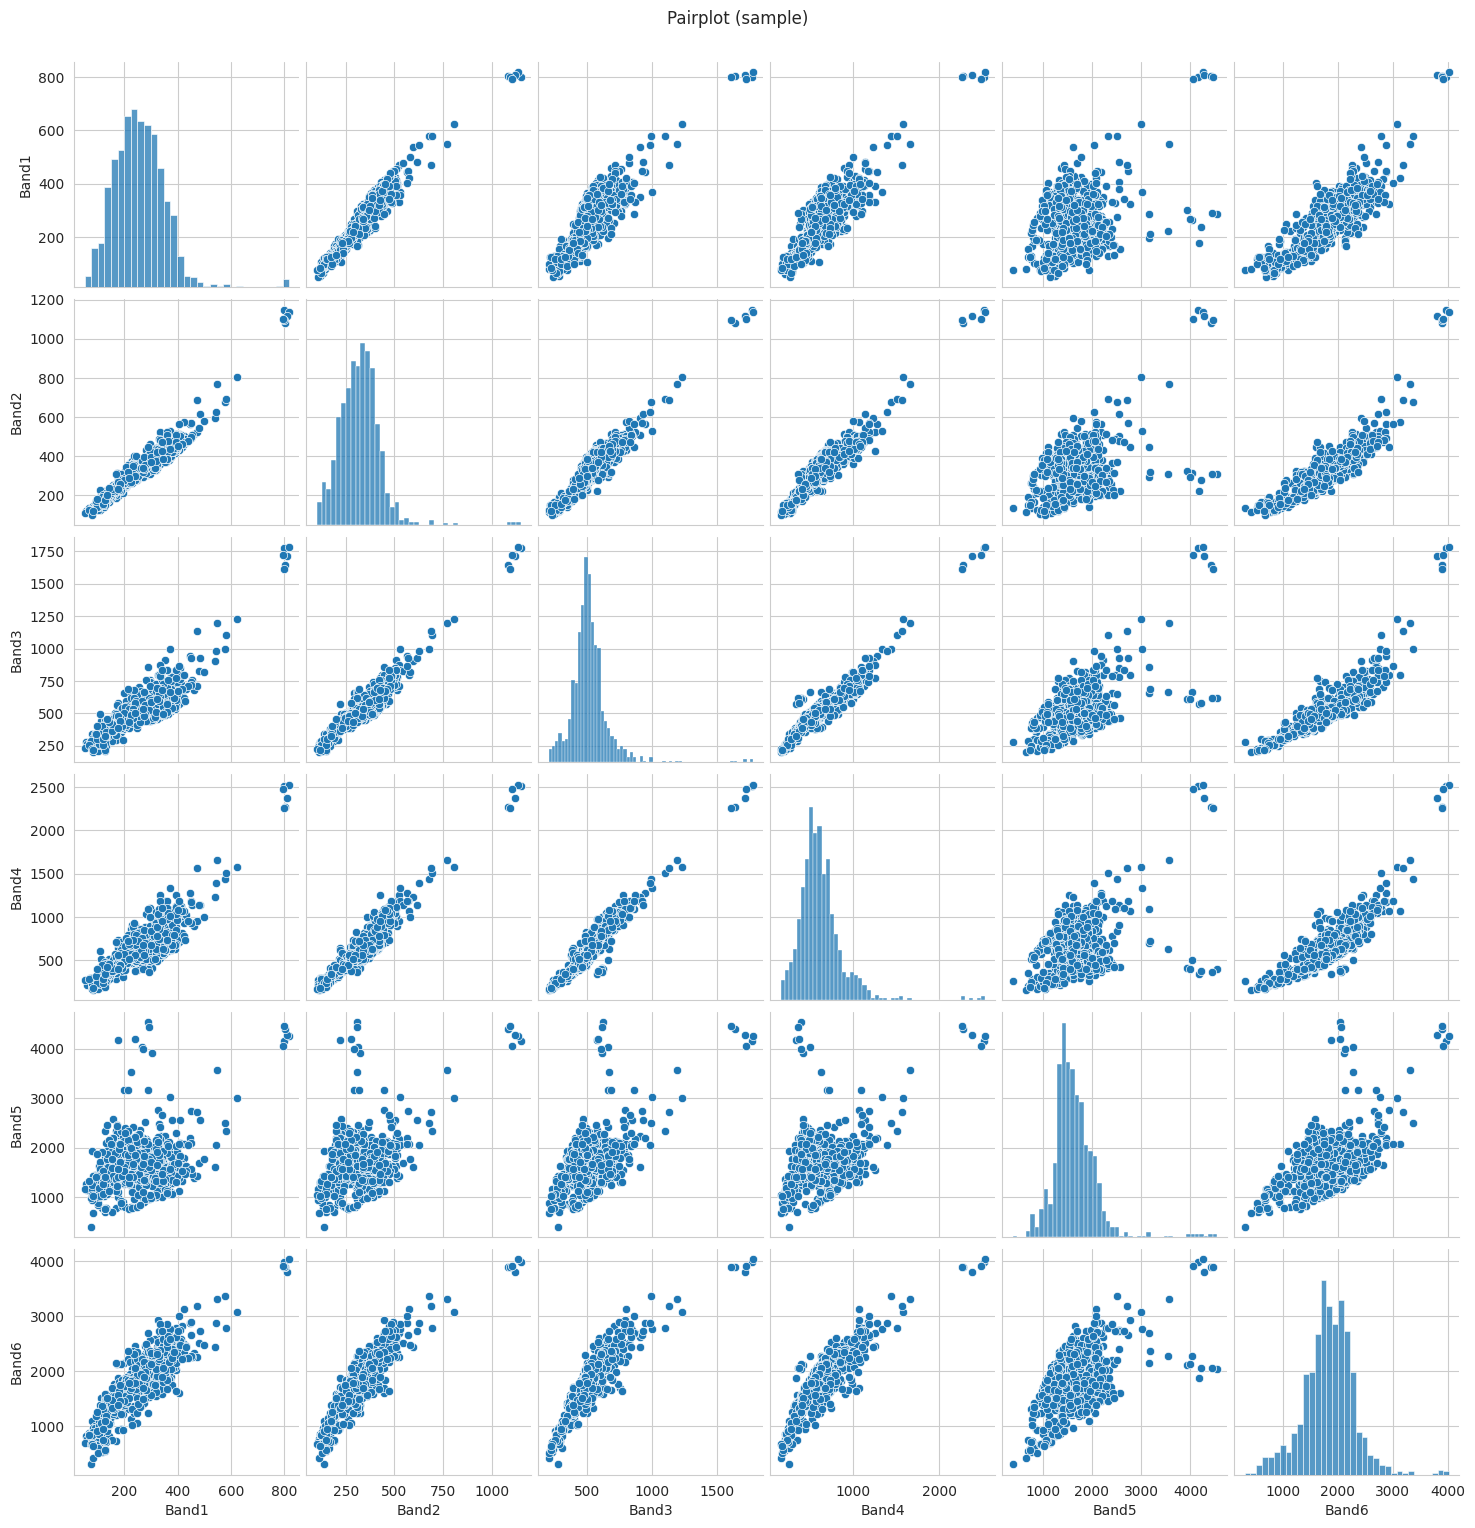

In [ ]:
# correlation heatmap of bands
corr = df[band_cols].corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0, ax=ax)
ax.set_title("Band correlation heatmap")
savefig(fig, "band_correlation_heatmap.png")
plt.show()

# pairplot (sample to keep it light)
sample = df[band_cols].sample(min(len(df), 1000), random_state=RANDOM_SEED)
pair_cols = band_cols if len(band_cols) <= 6 else band_cols[:6]
sns.pairplot(sample[pair_cols])
plt.suptitle("Pairplot (sample)", y=1.02)
plt.show()

# 4. Outlier and Missing Value Treatment

In [ ]:
print("Outlier treatment & missingness handling")
# Model columns = bands
model_cols = band_cols.copy()

# masks computed on original df to avoid misalignment
mask_na = df[model_cols].isna().any(axis=1)
z = np.abs(stats.zscore(df[model_cols].fillna(df[model_cols].mean()), axis=0))
outlier_mask = (z > 4).any(axis=1)

print("Total rows:", len(df))
print("Rows with NA in bands:", int(mask_na.sum()))
print("Rows flagged as extreme outliers (z>4):", int(outlier_mask.sum()))

# drop rows with NA or extreme outliers
keep_mask = (~mask_na) & (~outlier_mask)
df_clean = df.loc[keep_mask].copy().reset_index(drop=True)
print("Rows after cleaning:", len(df_clean))

# Save a log CSV of removed rows for traceability
removed = df.loc[~keep_mask].copy()
if not removed.empty:
    removed.to_csv(os.path.join(OUTDIR, "removed_rows_log.csv"), index=False)
    print("Saved removed rows log.")

# quick stats after cleaning
display(df_clean[model_cols].describe().T)

Outlier treatment & missingness handling
Total rows: 48848
Rows with NA in bands: 0
Rows flagged as extreme outliers (z>4): 579
Rows after cleaning: 48269
Saved removed rows log.


count         mean         std    min     25%     50%     75%     max
Band1  48269.0   249.076799   88.324590    0.0   185.0   244.0   311.0   624.0
Band2  48269.0   312.960306   94.913337   62.0   247.0   312.0   376.0   727.0
Band3  48269.0   503.363815  126.017289  149.0   435.0   497.0   559.0  1091.0
Band4  48269.0   602.396093  213.441120  121.0   468.0   576.0   704.0  1564.0
Band5  48269.0  1622.717500  376.513336  150.0  1380.0  1580.0  1854.0  3427.0
Band6  48269.0  1789.611966  451.669763  141.0  1534.0  1825.0  2065.0  3495.0
Band7  48269.0  1210.496861  423.380355  102.0   935.0  1195.0  1450.0  2937.0

# **Data Exploration and Cleaning**

The dataset was well organized and included complete geospatial coordinates consisting of Longitude and Latitude along with the full set of spectral bands. Minor missing values and extreme outliers with z scores above four were removed to ensure consistent model behaviour. The exploratory analysis showed strong correlations between several spectral bands which confirmed redundancy among neighbouring wavelengths. Bands 4, 5 and 6 showed distinct variability that reflects their different sensitivities to surface composition and mineralogical properties.

Spatial scatter plots showed smooth gradients across the area and these reflect changes in vegetation cover, soil exposure, and topographic effects.

# 5. Preprocessing and Scaling

In [ ]:
# Detect targets B4, B5, B6 robustly (case sensitive retention)
targets = [c for c in model_cols if c.lower().endswith(('4','5','6')) or c.lower() in ('band4','band5','band6')]
# fallback to explicit names if detection fuzzy
for n in [4,5,6]:
    name = f"Band{n}"
    if name in model_cols and name not in targets:
        targets.append(name)
targets = [t for t in targets if t in model_cols]
targets = list(dict.fromkeys(targets))  # unique preserve order

if len(targets) < 3:
    raise RuntimeError("Could not reliably detect Band4,Band5,Band6. Detected: {}".format(targets))
print("Targets detected:", targets)

# predictors = bands excluding targets
predictors = [c for c in model_cols if c not in targets]
print("Predictors count:", len(predictors))

# drop rows with NA in predictors/targets in cleaned df
model_df = df_clean.dropna(subset=predictors + targets).reset_index(drop=True)
print("Rows available for modelling:", len(model_df))

# feature matrix and target matrix
X = model_df[predictors].to_numpy()
y = model_df[targets].to_numpy()

# if coordinates exist, keep them to allow spatial mapping later
coords = None
if has_lonlat:
    coords = model_df[['Longitude', 'Latitude']].to_numpy()

# train-test split using index retention
indices = model_df.index.to_numpy()
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.25, random_state=RANDOM_SEED
)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# scale features (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


Targets detected: ['Band4', 'Band5', 'Band6']
Predictors count: 4
Rows available for modelling: 48269
Train size: 36201 Test size: 12068


# 6. Random Forest Regression

In [ ]:
base_rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
multi_rf = MultiOutputRegressor(base_rf)

param_distributions = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 12, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
search = RandomizedSearchCV(multi_rf, param_distributions, n_iter=6, cv=cv,
                            random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
search.fit(X_train_s, y_train)
print("Best params:", search.best_params_)

best_model = search.best_estimator_

# fit best_model fully on train set (RandomizedSearchCV already fits, but re-fit to be explicit)
best_model.fit(X_train_s, y_train)

# predict on test
y_pred = best_model.predict(X_test_s)

# store predictions in DataFrame aligned with model_df indices (test indices)
test_idx = idx_test
pred_df = pd.DataFrame(y_pred, columns=[f'pred_{t}' for t in targets], index=test_idx)
true_df = pd.DataFrame(y_test, columns=[f'true_{t}' for t in targets], index=test_idx)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'estimator__n_estimators': 300, 'estimator__min_samples_split': 2, 'estimator__max_depth': 12}


# 7. Model Evaluation

In [ ]:
metrics = {}
for i, t in enumerate(targets):
    mse = mean_squared_error(y_test[:,i], y_pred[:,i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test[:,i], y_pred[:,i])
    r2 = r2_score(y_test[:,i], y_pred[:,i])
    metrics[t] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

metrics_df = pd.DataFrame(metrics).T
print("Test metrics per band:")
display(metrics_df.round(4))

metrics_df.to_csv(os.path.join(OUTDIR, "test_metrics_per_band.csv"), index=True)
print("Saved test metrics to outputs/")

Test metrics per band:


RMSE       MAE      R2
Band4   33.2471   23.4785  0.9757
Band5  205.3924  144.5989  0.7042
Band6  121.5538   79.6531  0.9276

Saved test metrics to outputs/


# Regression Performance Random Forest

The Random Forest model demonstrated strong predictive performance when reconstructing Bands 4 to 6.

Band 4 and Band 6 were reconstructed with very high accuracy and both achieved R squared values above 0.92. This indicates consistent and stable spectral relationships with the other bands.
Band 5 was more difficult to reconstruct and its R squared of 0.70 confirms that near infrared behaviour is more complex and sensitive to vegetation and moisture driven variability.
The relatively low RMSE and MAE for Bands 4 and 6 show that the model generalized well.
Parity plots showed tight clustering near the one to one line for Bands 4 and 6 confirming their strong predictability while Band 5 showed more scatter.

These results confirm that the dataset contains strong interband redundancy which supports high fidelity spectral reconstruction.

# 8. Parity Plots

Saved outputs/parity_Band4.png


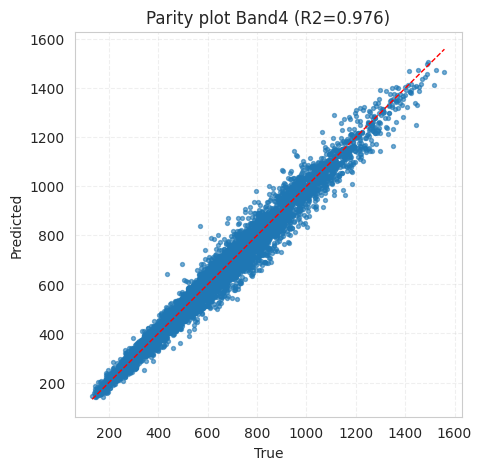

Saved outputs/parity_Band5.png


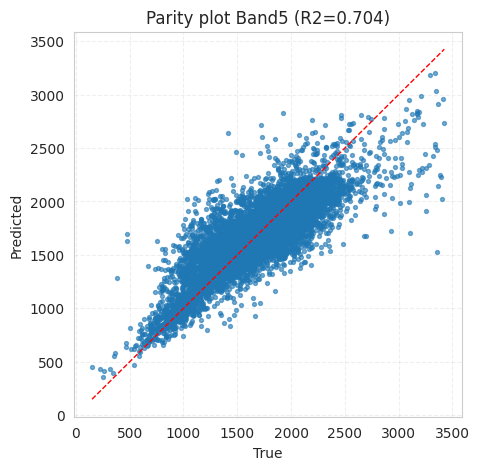

Saved outputs/parity_Band6.png


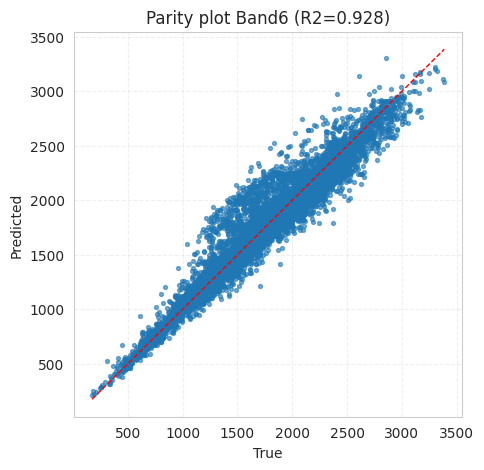

In [ ]:
for i, t in enumerate(targets):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_test[:,i], y_pred[:,i], s=8, alpha=0.6)
    mn = min(np.nanmin(y_test[:,i]), np.nanmin(y_pred[:,i]))
    mx = max(np.nanmax(y_test[:,i]), np.nanmax(y_pred[:,i]))
    ax.plot([mn,mx],[mn,mx], 'r--', lw=1)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(f'Parity plot {t} (R2={metrics[t]["R2"]:.3f})')
    ax.grid(alpha=0.3, linestyle='--')
    fname = f"parity_{t}.png"
    savefig(fig, fname)
    plt.show()

# 9. Residual Analysis

Saved residuals to outputs/
Saved outputs/resid_hist_r_Band4.png


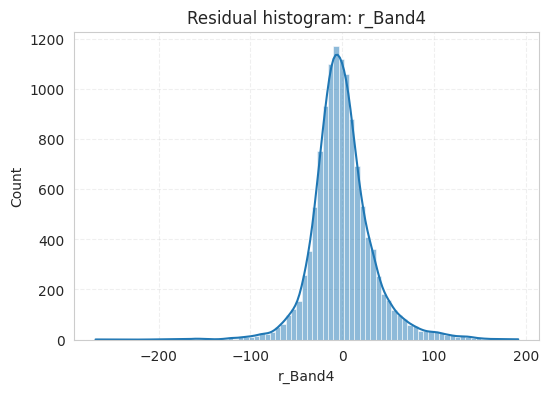

Saved outputs/resid_hist_r_Band5.png


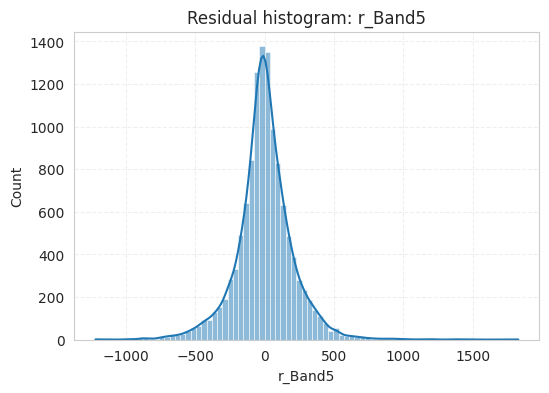

Saved outputs/resid_hist_r_Band6.png


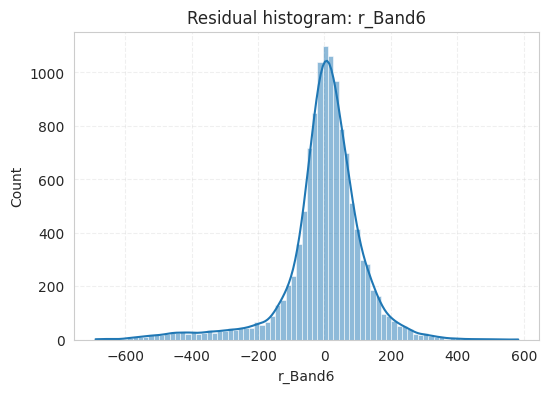

Saved outputs/residual_map_r_Band4.png


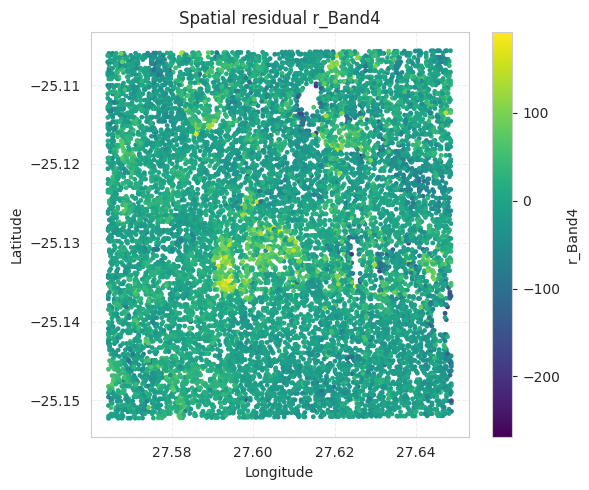

Saved outputs/residual_map_r_Band5.png


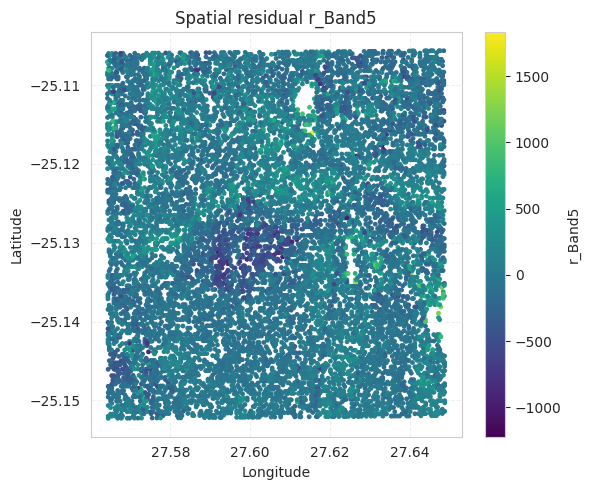

Saved outputs/residual_map_r_Band6.png


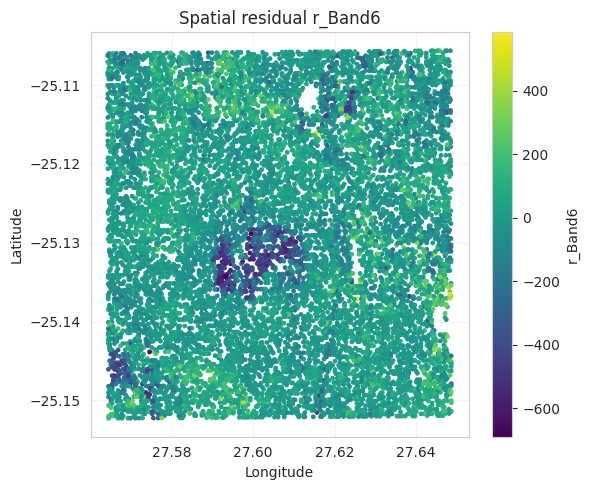

In [ ]:
residuals = y_test - y_pred  # y_true - y_pred
res_cols = [f"r_{t}" for t in targets]
res_df = pd.DataFrame(residuals, columns=res_cols, index=test_idx)

# attach coords if available (use model_df index mapping)
if has_lonlat:
    res_df['Longitude'] = model_df.loc[test_idx, 'Longitude'].values
    res_df['Latitude'] = model_df.loc[test_idx, 'Latitude'].values
    res_gdf = gpd.GeoDataFrame(res_df.copy(), geometry=gpd.points_from_xy(res_df.Longitude, res_df.Latitude), crs='EPSG:4326')
else:
    res_gdf = None

# save residuals table
res_df.to_csv(os.path.join(OUTDIR, "residuals_test_set.csv"), index=True)
print("Saved residuals to outputs/")

# residual histograms and spatial maps
for col in res_cols:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(res_df[col], bins=80, kde=True, ax=ax)
    ax.set_title(f"Residual histogram: {col}")
    ax.grid(alpha=0.3, linestyle='--')
    savefig(fig, f"resid_hist_{col}.png")
    plt.show()

# spatial residual maps if coords exist
if res_gdf is not None:
    for col in res_cols:
        quick_map_scatter(res_gdf, c=col, title=f"Spatial residual {col}", save_name=f"residual_map_{col}.png")
else:
    print("No coordinates to map residuals.")

# **Residual Analysis**

Residuals were calculated to identify local discrepancies. Their distributions were centered around zero which confirms that the model had no major global bias.

Spatial maps of residuals showed clear clusters of unusually high positive or negative errors. These clusters suggest real on ground variability that the model cannot fully explain. This includes ferric and ferrous mineral enrichment, areas with exposed soil or weathered surfaces, changes in vegetation density, and regions affected by subtle moisture or illumination differences.

# 10. PCA on Residuals

Explained variance ratio (PC1..PC3): [0.6474 0.2445 0.1081]


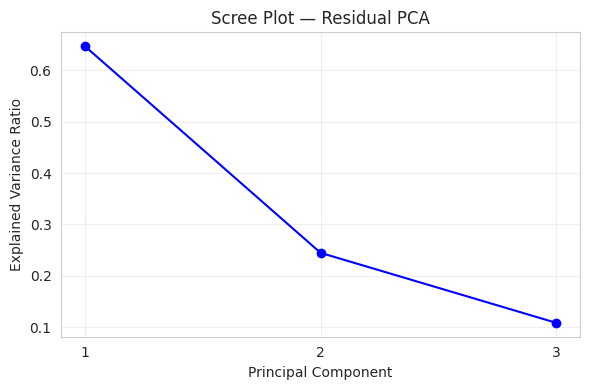


PCA loadings (residual bands):


PC1     PC2     PC3
r_Band4 -0.4744  0.8726  0.1165
r_Band5  0.6342  0.2470  0.7326
r_Band6  0.6105  0.4214 -0.6706

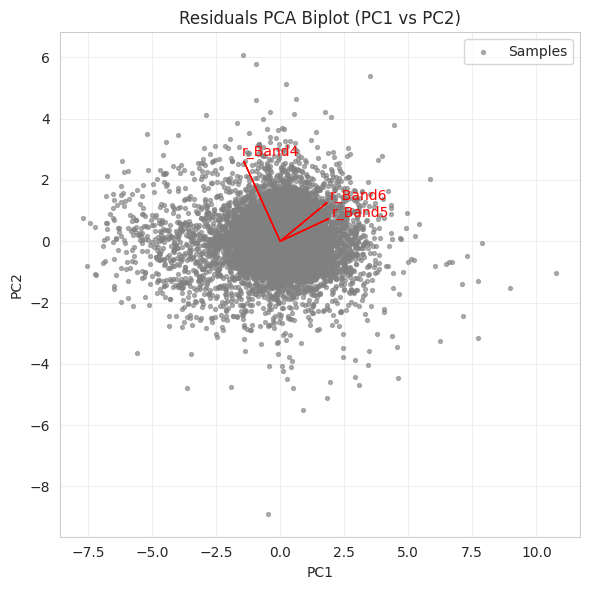

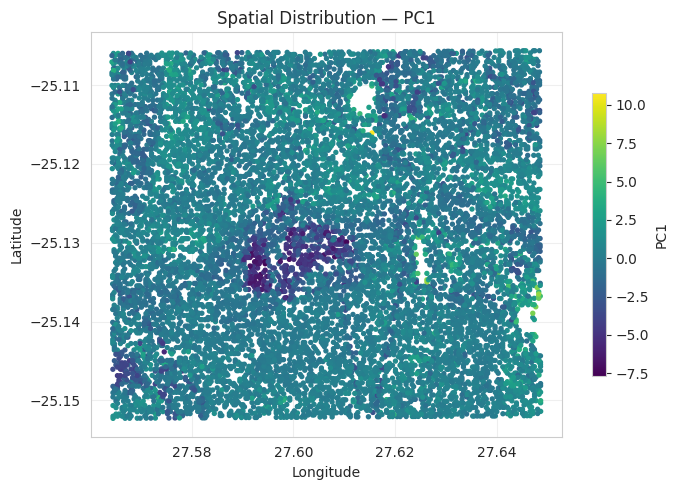

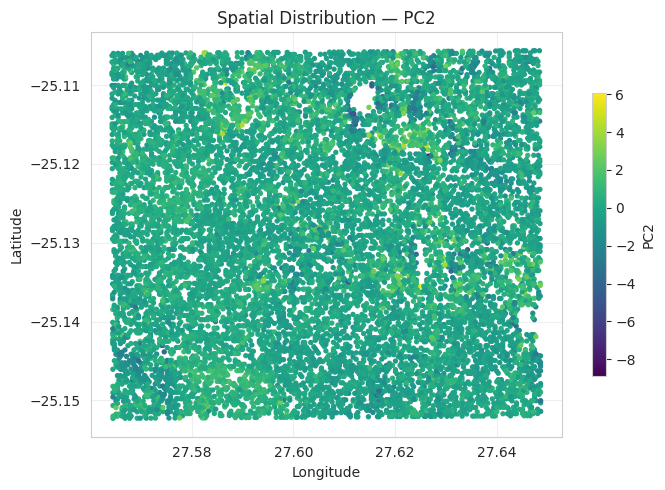

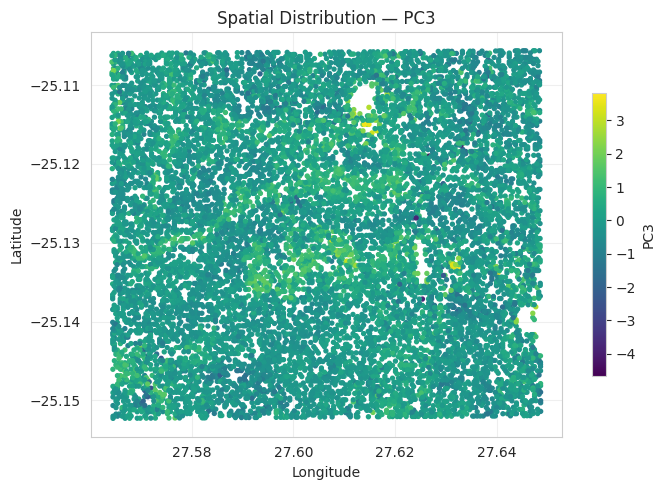

In [ ]:
# Configuration
SAVE_OUTPUTS = True
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Standardize residuals before PCA
X_res = res_df[res_cols].to_numpy()
scaler_res = StandardScaler()
X_res_s = scaler_res.fit_transform(X_res)

# Perform PCA
pca = PCA(n_components=3, random_state=RANDOM_SEED)
pcs = pca.fit_transform(X_res_s)
explained = pca.explained_variance_ratio_
print("Explained variance ratio (PC1..PC3):", explained.round(4))

# Scree plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, 4), explained, marker='o', color='blue')
ax.set_xticks([1, 2, 3])
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Scree Plot — Residual PCA")
ax.grid(alpha=0.3)
plt.tight_layout()
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUTDIR, "pca_scree_residuals.png"), dpi=300, bbox_inches='tight')
plt.show()

# Loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=res_cols,
    columns=['PC1', 'PC2', 'PC3']
)
print("\nPCA loadings (residual bands):")
display(loadings.round(4))

# Biplot (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(pcs[:,0], pcs[:,1], c='grey', s=8, alpha=0.6, label='Samples')
for i, t in enumerate(res_cols):
    ax.arrow(0, 0, loadings.loc[t, 'PC1']*3, loadings.loc[t, 'PC2']*3,
             color='red', head_width=0.05, length_includes_head=True)
    ax.text(loadings.loc[t, 'PC1']*3.2, loadings.loc[t, 'PC2']*3.2, t, color='red')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Residuals PCA Biplot (PC1 vs PC2)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUTDIR, "pca_biplot_residuals.png"), dpi=300, bbox_inches='tight')
plt.show()

# Spatial maps for each principal component
if 'Longitude' in res_df.columns and 'Latitude' in res_df.columns:
    for i in range(3):
        pc_name = f"PC{i+1}"
        res_df[pc_name] = pcs[:, i]
        plt.figure(figsize=(7,5))
        sc = plt.scatter(res_df['Longitude'], res_df['Latitude'], c=res_df[pc_name],
                         s=8, cmap='viridis')
        cb = plt.colorbar(sc, shrink=0.7)
        cb.set_label(pc_name)
        plt.title(f"Spatial Distribution — {pc_name}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        if SAVE_OUTPUTS:
            plt.savefig(os.path.join(OUTDIR, f"pc_map_{i+1}.png"), dpi=300, bbox_inches='tight')
        plt.show()


# **PCA on Residuals**

Principal Component Analysis was applied to standardized residuals to extract major spatial patterns.

1. PC1 has strong positive contributions from Band5 and Band6 residuals and a moderate negative contribution from Band4. It explains 64.74 percent of the variance and highlights broad scale spectral differences linked to iron minerals and moisture.

2. PC2 is dominated by Band4 residuals (0.8726) and captures medium scale patterns such as vegetation edges or illumination transitions. It explains 24.45 percent of the variance.

3. PC3 contrasts Band5 and Band6 residuals, capturing fine scale anomalies such as small mineralized patches or variable soil exposure. It explains 10.81 percent of the variance.

The first three components capture essentially all meaningful variation in residuals.
PC1 represents the broadest spectral discrepancy pattern and is likely linked to large scale geological and illumination related differences.
PC2 describes intermediate variation that is often connected to vegetation or terrain influences.
PC3 contains fine scale patterns and highlights small and sharp anomaly structures that may indicate exposed mineral patches or localized geochemical contrasts.

The PCA structure confirms that the residuals contain organized and meaningful spatial signals.

# 11. Compute Anomaly Scores

Anomaly score summary:


count    12068.0000
mean         0.1034
std          0.0972
min          0.0000
25%          0.0397
50%          0.0737
75%          0.1316
max          1.0000
Name: anomaly_score_norm, dtype: float64

Saved outputs/anomaly_score_map.png


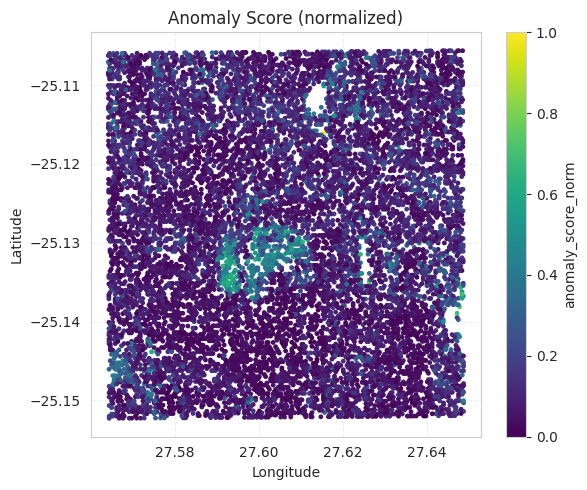

Threshold used: 0.995
Top anomalies count: 61
Saved top_anomalies.csv
Saved top_anomalies.geojson


r_Band4      r_Band5     r_Band6  Longitude   Latitude        PC1  \
28772   44.670555  -756.648443 -647.208838  27.598304 -25.133465  -6.214258   
31564   47.077609  -591.426112 -687.700995  27.598020 -25.136175  -5.941801   
27925  146.441444  -856.698155 -589.031289  27.594431 -25.132668  -7.683061   
39235  -16.767586  -875.143002 -625.489124  27.574544 -25.143854  -5.594455   
10755 -187.260389  1829.745183  487.802021  27.615478 -25.116056  10.782487   
29314   86.348353  -878.440946 -653.976103  27.593545 -25.134026  -7.218995   
32578 -121.649796   896.340222  391.881939  27.648319 -25.136776   6.482299   
27373   97.502526  -923.738398 -655.294755  27.593238 -25.132131  -7.524641   
24697 -177.922327  1381.434413  431.079136  27.625067 -25.129291   8.980003   
25429   96.606906  -642.445862 -594.130036  27.592336 -25.130238  -6.336038   

            PC2       PC3  anomaly_score  anomaly_score_norm dominant_PC  
28772 -1.977990  1.024640       4.617286            0.608968         PC1  
31564 -1.856540  1.845829       4.499987            0.593449         PC1  
27925  0.774436  0.703411       5.239074            0.691235         PC1  
39235 -3.657634  0.266847       4.544873            0.599388         PC1  
10755 -1.019735  3.176073       7.572793            1.000000         PC1  
29314 -1.054054  0.773574       5.014623            0.661539         PC1  
32578 -0.752714  0.605624       4.445874            0.586290         PC1  
27373 -0.820349  0.658354       5.142877            0.678507         PC1  
24697 -1.510398  1.922565       6.390425            0.843565         PC1  
25429 -0.293541  1.321171       4.316261            0.569141         PC1

In [ ]:
# weights = explained variance for PCs
weights = pca.explained_variance_ratio_
abs_pcs = np.abs(pcs)
anom_score = (abs_pcs * weights).sum(axis=1)  # weighted sum of absolute PC contributions
res_df['anomaly_score'] = anom_score
# normalize 0-1

res_df['anomaly_score_norm'] = (res_df['anomaly_score'] - res_df['anomaly_score'].min()) / np.ptp(res_df['anomaly_score'])
print("Anomaly score summary:")
display(res_df['anomaly_score_norm'].describe().round(4))

# add anomaly score to res_gdf if exists
if res_gdf is not None:
    res_gdf['anomaly_score_norm'] = res_df['anomaly_score_norm'].values

# save anomaly map
if res_gdf is not None:
    quick_map_scatter(res_gdf, c='anomaly_score_norm', title='Anomaly Score (normalized)', save_name='anomaly_score_map.png')
else:
    print("No coords to map anomaly score.")

# threshold for top anomalies (use 99.5% if enough points, else 95%)
quantile = 0.995 if len(res_df) >= 200 else 0.95
threshold = res_df['anomaly_score_norm'].quantile(quantile)
top_anoms = res_df[res_df['anomaly_score_norm'] >= threshold].copy()
print("Threshold used:", quantile)
print("Top anomalies count:", len(top_anoms))

# annotate dominant PC for each anomaly
pc_cols = [f"PC{i+1}" for i in range(3)]
if not top_anoms.empty:
    top_anoms['dominant_PC'] = (top_anoms[pc_cols].abs()).idxmax(axis=1)

# save table and GeoJSON if coords exist
if not top_anoms.empty:
    top_anoms_out = top_anoms.copy()
    if 'Longitude' in top_anoms_out.columns and 'Latitude' in top_anoms_out.columns:
        top_anoms_out[['Longitude','Latitude','anomaly_score_norm','dominant_PC']].to_csv(os.path.join(OUTDIR, "top_anomalies.csv"), index=False)
        print("Saved top_anomalies.csv")
        # GeoJSON
        try:
            gtop = gpd.GeoDataFrame(top_anoms_out, geometry=gpd.points_from_xy(top_anoms_out.Longitude, top_anoms_out.Latitude), crs='EPSG:4326')
            gtop.to_file(os.path.join(OUTDIR, "top_anomalies.geojson"), driver='GeoJSON')
            print("Saved top_anomalies.geojson")
        except Exception as e:
            print("Could not save geojson:", e)
    else:
        top_anoms_out.to_csv(os.path.join(OUTDIR, "top_anomalies.csv"), index=False)
        print("Saved top_anomalies.csv (no coordinates)")

# display sample top anomalies
if not top_anoms.empty:
    display(top_anoms.head(10))

# **Anomaly Scores**

An anomaly score was calculated from absolute PCA values to identify points that deviate significantly from expected spectral behaviour.

Summary of anomaly scores
Mean equals 0.1034
Median equals 0.0737
Seventy fifth percentile equals 0.1316
Maximum equals 1.0000
Standard deviation equals 0.0972

Interpretation
Most pixels had low anomaly scores below approximately 0.15 which suggests that the majority of the area shows normal spectral behaviour.
A smaller group of pixels showed moderate scores and these are associated with subtle but consistent local anomalies.
The highest scores extend up to 1.0 and represent strong and distinct spectral deviations. These extreme anomalies form coherent spatial clusters and are likely associated with iron rich alteration zones, strongly weathered surfaces, or mining related disturbances.

These zones are highly significant and represent high interest targets for further geological or mineralogical investigation.

# **Challenges and Recommendations**

1. Data Noise and Spatial Autocorrelation:
Some residual patterns reflect sensor or atmospheric noise rather than true surface variability. Applying localized filtering or cross-validation with field data could improve interpretation confidence.

2. Model Generalization:
While R² values were high, slight overfitting may exist. Increasing training diversity or testing alternative ensemble models could further stabilize predictions.

3. Ground Validation:
High-score anomalies should be validated through field sampling or hyperspectral follow-ups to confirm their geological origin.

4. Future Work:
Incorporating texture metrics, additional spectral ratios, or terrain attributes may enhance anomaly separability and improve precision mapping.